In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model

In [2]:
train_data = tfds.load("rock_paper_scissors", split="train", shuffle_files=True, as_supervised=True)

In [3]:
test_data = tfds.load("rock_paper_scissors", split="test", shuffle_files=True, as_supervised=True)

In [4]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 150

def augment(dataset):
  model = tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.2),
      layers.RandomZoom(0.2)
      ])
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(lambda x, y: (model(x, training=True), y), 
              num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
normalization_layer = layers.Rescaling(1./255)
resizing_layer = layers.Resizing(IMG_SIZE,IMG_SIZE)

normalized_train_data = train_data.map(lambda x, y: (resizing_layer(normalization_layer(x)), y))
normalized_test_data = test_data.map(lambda x, y: (resizing_layer(normalization_layer(x)), y))

In [6]:
img_input = layers.Input(shape=(150,150,3))

x = layers.Conv2D(16, 3, activation="relu")(img_input)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64, 3, activation="relu", kernel_regularizer="l2")(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu", activity_regularizer="l2")(x)
x = layers.Dropout(0.5)(x)

output = layers.Dense(3, activation="softmax")(x)

model = Model(img_input, output)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496 

In [8]:
! kaggle datasets download glushko/rock-paper-scissors-dataset

rock-paper-scissors-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
ext_train_data = tf.keras.utils.image_dataset_from_directory(".//train",image_size=(150, 150), class_names=["rock","paper","scissors"],shuffle=True, batch_size=None)
ext_train_data = ext_train_data.map(lambda x, y: (normalization_layer(x), tf.cast(y,tf.int64)))
ext_test_data = tf.keras.utils.image_dataset_from_directory(".//test",image_size=(150, 150), class_names=["rock","paper","scissors"],shuffle=True, batch_size=32)
ext_test_data = ext_test_data.map(lambda x, y: (normalization_layer(x), tf.cast(y,tf.int64)))
ext_val_data = tf.keras.utils.image_dataset_from_directory(".//val",image_size=(150,150), class_names=["rock","paper","scissors"],shuffle=True, batch_size=None)
ext_val_data = ext_val_data.map(lambda x, y: (normalization_layer(x), tf.cast(y,tf.int64)))

Found 1020 files belonging to 3 classes.
Found 540 files belonging to 3 classes.
Found 804 files belonging to 3 classes.


In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_acc', patience=5, verbose=1, mode='max')
model_checkpoint = ModelCheckpoint('./my_model.hdf5', save_best_only=True, save_weights_only=True, monitor='val_acc', mode='max')
reduce_lr= ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Adam(learning_rate=0.001),
              metrics=["acc"])

In [11]:
merged_train_data = normalized_train_data.concatenate(ext_train_data)
merged_val_data = normalized_test_data.concatenate(ext_val_data)

In [12]:
merged_train_data = merged_train_data.concatenate(merged_train_data)

In [ ]:
batched_merged_train_data = augment(merged_train_data)
batched_merged_val_data = merged_val_data.batch(batch_size)

In [ ]:
batched_train_data = augment(normalized_train_data)
batched_test_data = normalized_test_data.batch(batch_size)
batched_ext_train_data = augment(ext_train_data)
batched_ext_val_data = ext_val_data.batch(batch_size)

In [15]:
history = model.fit(batched_merged_train_data,
                    epochs=30,
                    validation_data=batched_merged_val_data,
                    callbacks=[early_stopping, model_checkpoint],
                    shuffle=True)

Epoch 1/30
222/222 [==============================] - 22s 79ms/step - loss: 1.0166 - acc: 0.6297 - val_loss: 1.1153 - val_acc: 0.4753
Epoch 2/30
222/222 [==============================] - 21s 95ms/step - loss: 0.6067 - acc: 0.8240 - val_loss: 1.0246 - val_acc: 0.5425
Epoch 3/30
222/222 [==============================] - 19s 85ms/step - loss: 0.4608 - acc: 0.8653 - val_loss: 0.9517 - val_acc: 0.5978
Epoch 4/30
222/222 [==============================] - 20s 87ms/step - loss: 0.3894 - acc: 0.8856 - val_loss: 0.9131 - val_acc: 0.6122
Epoch 5/30
222/222 [==============================] - 20s 87ms/step - loss: 0.3462 - acc: 0.8960 - val_loss: 0.8955 - val_acc: 0.6310
Epoch 6/30
222/222 [==============================] - 22s 100ms/step - loss: 0.3234 - acc: 0.8972 - val_loss: 0.9716 - val_acc: 0.5842
Epoch 7/30
222/222 [==============================] - 21s 93ms/step - loss: 0.2902 - acc: 0.9130 - val_loss: 0.9097 - val_acc: 0.5927
Epoch 8/30
222/222 [==============================] - 23s 103

Text(0.5, 1.0, 'Training and validation loss')

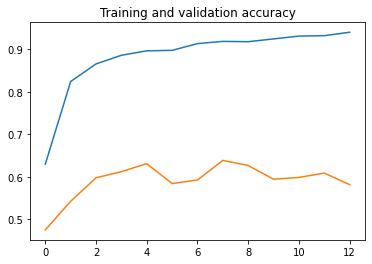

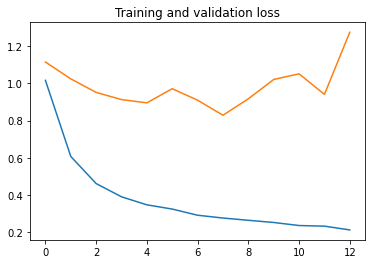

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

import matplotlib.pyplot as plt

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [17]:
model.evaluate(ext_test_data)

17/17 [==============================] - 1s 46ms/step - loss: 1.6846 - acc: 0.3889


[1.6845552921295166, 0.3888888955116272]

In [18]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [19]:
pre_trained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False)

In [20]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [21]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [22]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(3, activation='softmax')(x)

model = Model(pre_trained_model.input, x)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['acc'])

c:\python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [23]:
history = model.fit(batched_merged_train_data,
                    epochs=20,
                    validation_data=batched_merged_val_data,
                    callbacks=[early_stopping ,model_checkpoint],
                    shuffle=True)

Epoch 1/20
222/222 [==============================] - 31s 112ms/step - loss: 0.2445 - acc: 0.9109 - val_loss: 0.4287 - val_acc: 0.8316
Epoch 2/20
222/222 [==============================] - 22s 98ms/step - loss: 0.0761 - acc: 0.9742 - val_loss: 0.4373 - val_acc: 0.8444
Epoch 3/20
222/222 [==============================] - 23s 100ms/step - loss: 0.0520 - acc: 0.9833 - val_loss: 0.4664 - val_acc: 0.8308
Epoch 4/20
222/222 [==============================] - 23s 104ms/step - loss: 0.0354 - acc: 0.9880 - val_loss: 0.5465 - val_acc: 0.8112
Epoch 5/20
222/222 [==============================] - 21s 94ms/step - loss: 0.0649 - acc: 0.9797 - val_loss: 0.5764 - val_acc: 0.8282
Epoch 6/20
222/222 [==============================] - 21s 92ms/step - loss: 0.0366 - acc: 0.9876 - val_loss: 0.5602 - val_acc: 0.8010
Epoch 7/20
222/222 [==============================] - 21s 91ms/step - loss: 0.0280 - acc: 0.9910 - val_loss: 0.5774 - val_acc: 0.8231
Epoch 7: early stopping


In [24]:
model.evaluate(ext_test_data)

17/17 [==============================] - 2s 100ms/step - loss: 1.0976 - acc: 0.6759


[1.0975542068481445, 0.6759259104728699]